In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor


from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob


from MyDataLoader import ShuffleDataLoader
from FileReader import get_picture_tensors
from MyModels import SimpleCNN
from ModelEvaluation import eval_model

from ImageProcessing import display_train_and_test_images


In [25]:
# data params
root_directory = "selected_datasets/prep_no_back/"
n_classes = 30
required_train_imgs = 8
required_test_imgs = 1

In [26]:
root_dir = "dataset_chat_eliot_downscale"
# root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels, n_classes) = get_picture_tensors(root_directory=root_directory,
                                                              n_classes=n_classes, 
                                                              required_train_imgs=required_train_imgs, 
                                                              required_test_imgs=required_test_imgs,
                                                              use_selected_eval_datasets = False)

Chargement de selected_datasets/prep_no_back/0001  ->  10/17 images
Chargement de selected_datasets/prep_no_back/0002  ->  10/15 images
Chargement de selected_datasets/prep_no_back/0003  ->  10/15 images
Chargement de selected_datasets/prep_no_back/0004  ->  10/17 images
Chargement de selected_datasets/prep_no_back/0005  ->  10/15 images
Chargement de selected_datasets/prep_no_back/0006  ->  10/17 images
Chargement de selected_datasets/prep_no_back/0007  ->  10/16 images
Chargement de selected_datasets/prep_no_back/0008  ->  10/17 images


Chargement de selected_datasets/prep_no_back/0010  ->  10/19 images
Chargement de selected_datasets/prep_no_back/0011  ->  10/18 images
Chargement de selected_datasets/prep_no_back/0012  ->  10/15 images
Chargement de selected_datasets/prep_no_back/0015  ->  10/20 images
Chargement de selected_datasets/prep_no_back/0016  ->  10/14 images
Chargement de selected_datasets/prep_no_back/0017  ->  10/18 images
Chargement de selected_datasets/prep_no_back/0018  ->  10/22 images
Chargement de selected_datasets/prep_no_back/0019  ->  10/15 images
Chargement de selected_datasets/prep_no_back/0020  ->  10/16 images
Chargement de selected_datasets/prep_no_back/0022  ->  10/16 images
Chargement de selected_datasets/prep_no_back/0024  ->  10/14 images
Chargement de selected_datasets/prep_no_back/0026  ->  10/17 images
Chargement de selected_datasets/prep_no_back/0027  ->  10/14 images
Chargement de selected_datasets/prep_no_back/0029  ->  10/25 images
Chargement de selected_datasets/prep_no_back/003

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

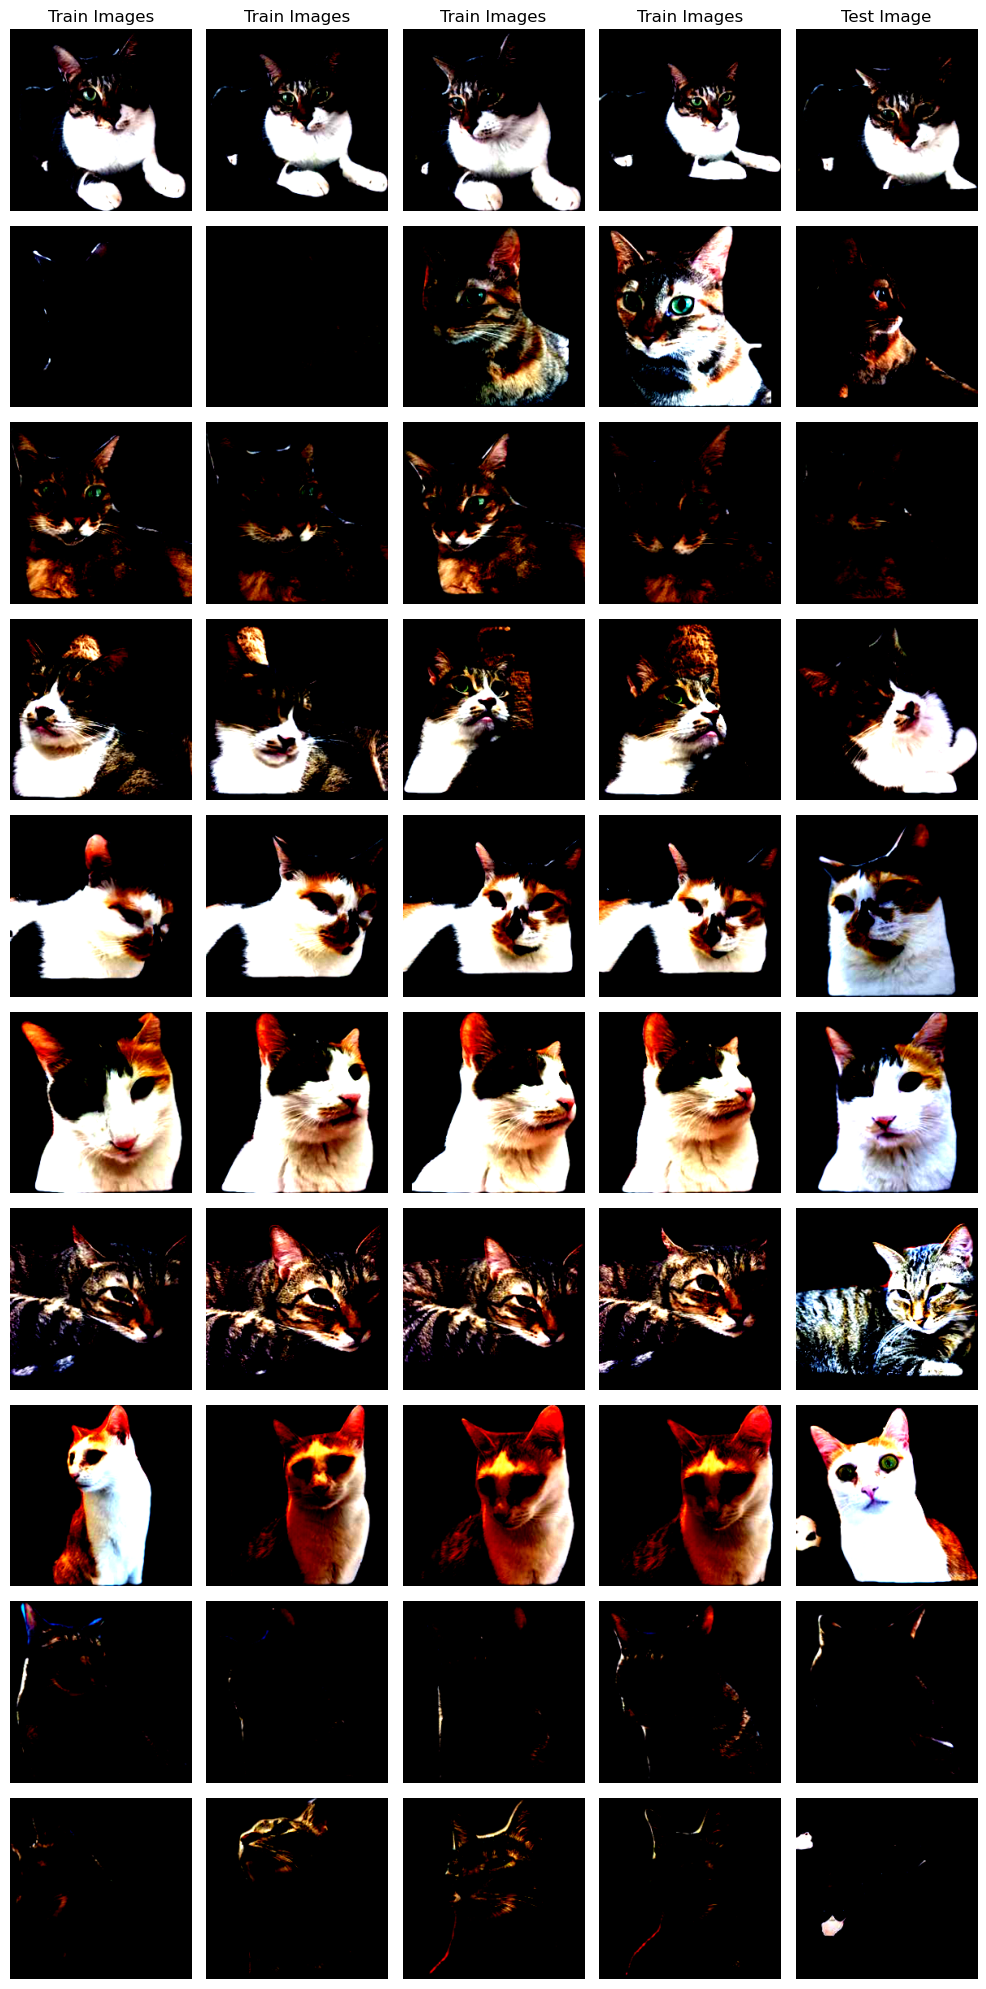

In [27]:
#  (1,2,0) avec du preprocessing, (0,1,2) sans, jsp pourquoi
# il y aura du spam de warning, ignore ça
display_train_and_test_images(train_images, test_images, required_train_imgs, (1,2,0))

In [28]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
# num_epochs = 6
num_epochs = 4
batch_size = 8
learning_rate = 1e-3


train_dataset = ShuffleDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataset = ShuffleDataLoader(val_images, val_labels)


# model = SimpleCNN(n_classes)
# model = SimpleCNN(n_classes, pretrained = False, train_hidden_layer = True)
# model = SimpleCNN(n_classes, pretrained = True, train_hidden_layer = True)

model = CatNet(n_classes)

model.train()

criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)

# Gossage sur les params potentiel
# momentum = 0.5
# weight_decay = 1e-5 
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
# criterion = nn.CrossEntropyLoss(reduction = 'none')
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(params, lr = learning_rate, weight_decay = weight_decay)
# optimizer = optim.SGD(params, lr = learning_rate, momentum = momentum)   

accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"End of epoch {epoch}")
    accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
    
print('Training and evaluation finished.')

End of epoch 0
Accuracy on validation dataset: 30.00%
End of epoch 1
Accuracy on validation dataset: 63.33%
End of epoch 2
Accuracy on validation dataset: 73.33%
End of epoch 3
Accuracy on validation dataset: 76.67%
Training and evaluation finished.


In [29]:
# # Décommenter pour rouler d'autre épochs supplémentaires sans repartir de 0
# for epoch in range(num_epochs):
#     for images, labels in train_dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
# print('Training and evaluation finished.')

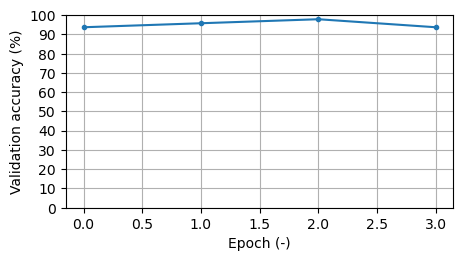

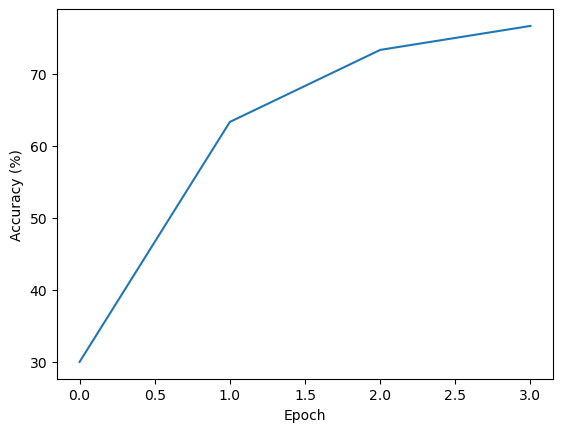

In [6]:
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

ax.set_xlabel('Epoch (-)')
ax.set_ylabel('Validation accuracy (%)')
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 110, 10))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.plot(accuracy_at_each_epoch, '.-')

plt.grid(True)


In [7]:
# # Pour loader des nouvelles données à tester
# # Problème avec les labels!

# # root_dir = "dataset_chat_downscale"
# root_dir = "dataset_chat_downscale_no_background"
# (train_images, val_images, test_images, 
#  train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes,
#                                                required_train_imgs=required_test_imgs,
#                                                required_test_imgs=required_test_imgs)

# # array of 10 zeros
# index = np.zeros(len(test_images))
# score = np.zeros(len(test_images))
# for i in range(len(test_images)-1, 0, -1):
#     test_images = test_images[:i]  # sa réduit la taille jusqu'à 0.. 
#     test_labels = test_labels[:i]
#     test_dataset = ShuffleDataLoader(test_images, test_labels)
#     # print(test_labels_i)
#     index[i] = i
#     score[i] = eval_model(model, test_dataset)

In [30]:
# plt.plot(index, score)
# plt.xlabel('Number of test images')
# plt.ylabel('Accuracy (%)')

Accuracy on test dataset: 83.33%


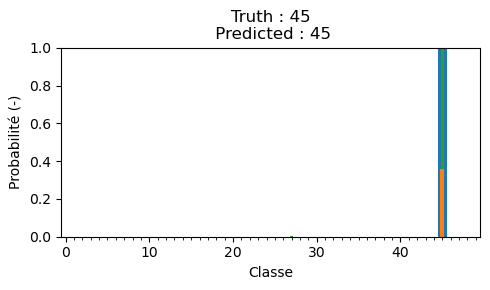

In [9]:
test_dataset = ShuffleDataLoader(test_images, test_labels)
eval_model(model, test_dataset, type_of_dataset="test")